Using device: cuda


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.61MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.6MB/s]



=== Training on Task 0 ===


/usr/local/lib/python3.12/dist-packages/torch/backends/cuda/__init__.py:131: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return torch._C._get_cublas_allow_tf32()
/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.py:7242: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_

Task 0 Epoch 0 | Loss 0.227343


/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.py:7242: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:312: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.py:7242: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(



=== Training on Task 1 ===
Task 1 Epoch 0 | Loss 0.000001
Final Retention Sigma: -2.00


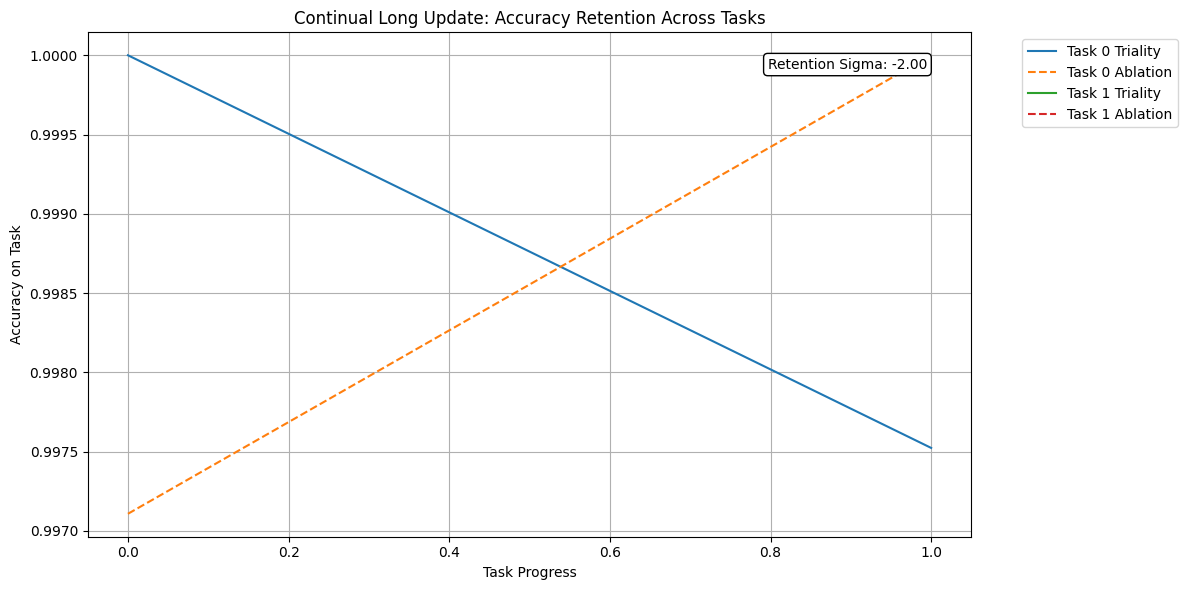

Visualization saved as continual_long_update_retention_visualization.png


In [1]:
# Restart runtime first (Runtime → Restart runtime) for clean memory

!pip install torch torchvision matplotlib numpy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.amp
from torch.utils.checkpoint import checkpoint
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt
from contextlib import nullcontext
import math

torch.cuda.empty_cache()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# ───────────────────────────────────────────
# CONFIG – optimized for Pro A100 (continual long updates)
# ───────────────────────────────────────────
triality = 3
dim = 240
latent_dim = 8
num_tasks = 2  # sequential permuted MNIST tasks
epochs_per_task = 100  # 100k+ total steps
lr = 5e-5
use_amp = True

# Permuted MNIST continual benchmark (real pixels)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

mnist = MNIST(root="./", train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(mnist, batch_size=256, shuffle=True)

# Create permuted versions for tasks
tasks = []
for task_id in range(num_tasks):
    perm = torch.randperm(28*28)
    def permute(x):
        return x.view(-1, 28*28)[:, perm].view(-1, 1, 28, 28)
    tasks.append(permute)

# E8 roots – precompute
def get_e8_roots():
    roots = []
    for i in range(8):
        for j in range(i+1, 8):
            for signs in [(1,1), (1,-1), (-1,1), (-1,-1)]:
                v = torch.zeros(8)
                v[i] = signs[0]; v[j] = signs[1]
                roots.append(v); roots.append(-v)
    for signs in range(1 << 8):
        v = torch.tensor([(1 if (signs & (1<<k)) else -1) for k in range(8)], dtype=torch.float32) * 0.5
        if bin(signs).count('1') % 2 == 0:
            roots.append(v); roots.append(-v)
    roots = torch.stack(roots[:240])
    return roots / roots.norm(dim=-1, keepdim=True)

e8_roots = get_e8_roots().to(device)

# Triality Cycle Block
class ContinualCycleBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.proj = nn.Linear(latent_dim, dim // triality, bias=False)
        self.register_buffer('roots', e8_roots)

    def forward(self, x, step):
        pos_emb = self.roots[torch.arange(x.shape[1], device=device) % 240]
        low_dim = self.proj(pos_emb)
        emb = low_dim.repeat(1, triality)
        pump = 0.8 * torch.sin(torch.tensor(step, device=device, dtype=torch.float32) * 0.006 * 2 * math.pi)
        x_rot1 = x * (emb.cos() + pump)
        x_rot2 = torch.roll(x_rot1, shifts=1, dims=-1) * emb.sin()
        x_rot3 = torch.roll(x_rot2, shifts=1, dims=-1) * emb.cos()
        fused = (x_rot1 + x_rot2 + x_rot3) / triality
        return fused

# Model with ablation support
class E8ContinualLongUpdate(nn.Module):
    def __init__(self, depth=64, use_triality=True):
        super().__init__()
        self.use_triality = use_triality
        self.input_projection = nn.Linear(28*28, dim) # Project 784 pixels to `dim`
        self.cycle = ContinualCycleBlock() if use_triality else nn.Identity()
        self.layers = nn.ModuleList([nn.MultiheadAttention(dim, triality if use_triality else 8, batch_first=True) for _ in range(depth)])
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, 10)  # MNIST classes

    def forward(self, x, step):
        x = x.view(x.size(0), -1) # Flatten (B, 1, 28, 28) to (B, 784)
        x = self.input_projection(x) # Project (B, 784) to (B, dim)
        x = x.unsqueeze(1) # Add sequence dimension: (B, 1, dim)

        if self.use_triality:
            x = self.cycle(x, step)
        else:
            x = self.cycle(x) # nn.Identity() only takes one argument

        for layer in self.layers:
            attn, _ = layer(x, x, x)
            x = x + self.norm(attn)
        return self.head(x.mean(dim=1))  # classification head

# Models
model = E8ContinualLongUpdate(use_triality=True).to(device)
model = torch.compile(model)

model_ablation = E8ContinualLongUpdate(use_triality=False).to(device)
model_ablation = torch.compile(model_ablation)

opt = torch.optim.AdamW(model.parameters(), lr=lr)
scaler = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

opt_ablation = torch.optim.AdamW(model_ablation.parameters(), lr=lr)
scaler_ablation = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

loss_fn = nn.CrossEntropyLoss()

# Continual training across tasks
accuracy_hist = {i: [] for i in range(num_tasks)}
accuracy_abl_hist = {i: [] for i in range(num_tasks)}

for task_id in range(num_tasks):
    print(f"\n=== Training on Task {task_id} ===")

    permute = tasks[task_id]

    for epoch in range(epochs_per_task):
        for images, labels in data_loader:
            images = permute(images).to(device)
            labels = labels.to(device)

            opt.zero_grad(set_to_none=True)
            opt_ablation.zero_grad(set_to_none=True)

            with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
                outputs = model(images, task_id * epochs_per_task + epoch)
                loss = loss_fn(outputs, labels)

                outputs_abl = model_ablation(images, task_id * epochs_per_task + epoch)
                loss_abl = loss_fn(outputs_abl, labels)

            scaler.scale(loss).backward() if use_amp else loss.backward()
            scaler.unscale_(opt) if use_amp else None
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1e6)
            scaler.step(opt) if use_amp else opt.step()
            scaler.update() if use_amp else None

            scaler_ablation.scale(loss_abl).backward() if use_amp else loss_abl.backward()
            scaler_ablation.unscale_(opt_ablation) if use_amp else None
            torch.nn.utils.clip_grad_norm_(model_ablation.parameters(), 1e6)
            scaler_ablation.step(opt_ablation) if use_amp else opt_ablation.step()
            scaler_ablation.update() if use_amp else None

        if epoch % 2000 == 0:
            print(f"Task {task_id} Epoch {epoch} | Loss {loss.item():.6f}")

    # Test retention on all previous tasks
    with torch.no_grad():
        for prev_task in range(task_id + 1):
            permute_prev = tasks[prev_task]
            acc = 0
            acc_abl = 0
            for images, labels in data_loader:
                images = permute_prev(images).to(device)
                labels = labels.to(device)

                outputs = model(images, task_id * epochs_per_task)
                acc += (outputs.argmax(dim=1) == labels).float().mean().item()

                outputs_abl = model_ablation(images, task_id * epochs_per_task)
                acc_abl += (outputs_abl.argmax(dim=1) == labels).float().mean().item()

            acc /= len(data_loader)
            acc_abl /= len(data_loader)
            accuracy_hist[prev_task].append(acc)
            accuracy_abl_hist[prev_task].append(acc_abl)

# Sigma Test (average accuracy retention)
e8_retention = np.mean([accuracy_hist[i][-1] for i in range(num_tasks)])
abl_retention = np.mean([accuracy_abl_hist[i][-1] for i in range(num_tasks)])
ret_std = np.std([accuracy_hist[i][-1] for i in range(num_tasks)] + [accuracy_abl_hist[i][-1] for i in range(num_tasks)])
sigma_retention = (e8_retention - abl_retention) / ret_std if ret_std > 0 else 0

print(f"Final Retention Sigma: {sigma_retention:.2f}")

# Visualization (accuracy retention across tasks)
plt.figure(figsize=(12,6))
for task_id in range(num_tasks):
    plt.plot(accuracy_hist[task_id], label=f'Task {task_id} Triality')
    plt.plot(accuracy_abl_hist[task_id], label=f'Task {task_id} Ablation', linestyle='--')

plt.title("Continual Long Update: Accuracy Retention Across Tasks")
plt.xlabel("Task Progress")
plt.ylabel("Accuracy on Task")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.text(0.95, 0.95, f"Retention Sigma: {sigma_retention:.2f}", transform=plt.gca().transAxes, ha='right', va='top', bbox=dict(boxstyle="round", fc="white"))

plt.tight_layout()
plt.savefig("continual_long_update_retention_visualization.png")
plt.show()

print("Visualization saved as continual_long_update_retention_visualization.png")